In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

## 삼성전자 주식 예측

### 데이터 불러오기

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


### 시계열 생성

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [4]:
ts.tail()

Date
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, dtype: float64

### 결측치 처리

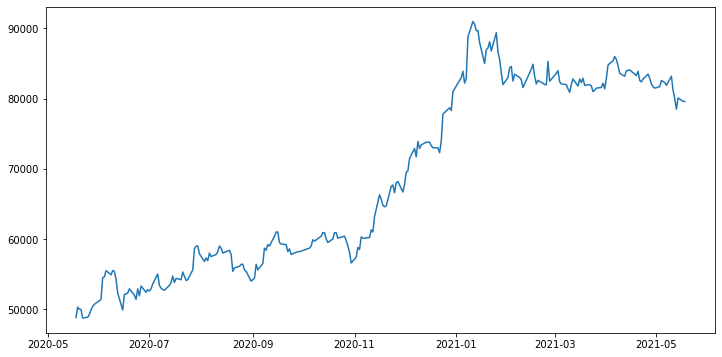

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(ts)

In [6]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 로그 변환

In [7]:
ts_log = np.log(ts)

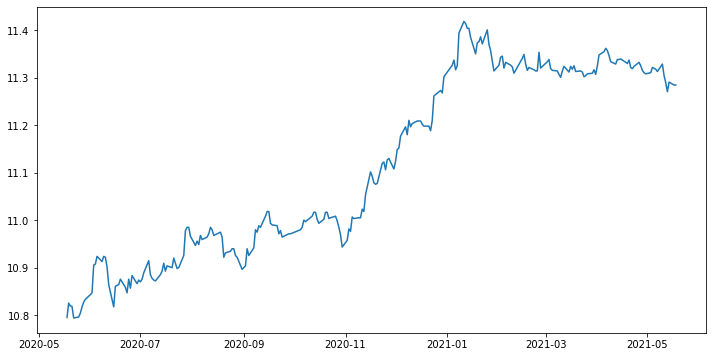

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(ts_log)

### 시계열 안정성 분석

In [9]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [10]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

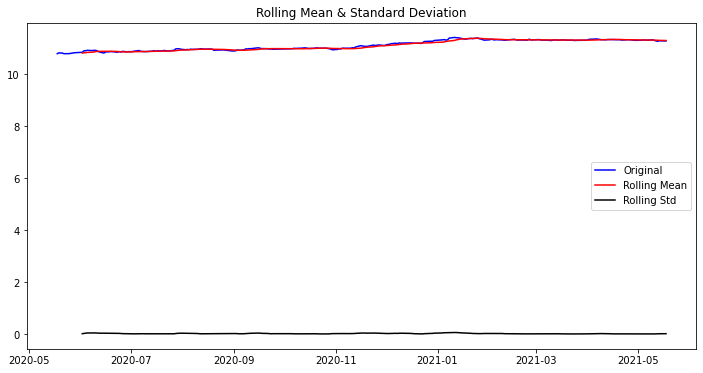

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


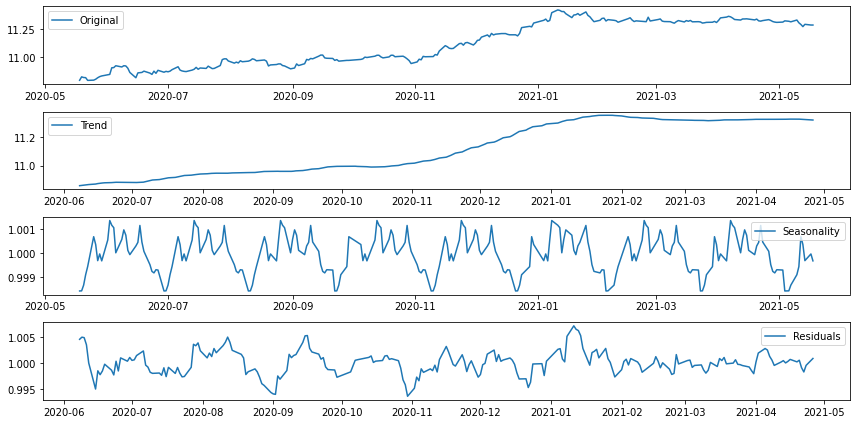

In [11]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### 데이터셋 생성

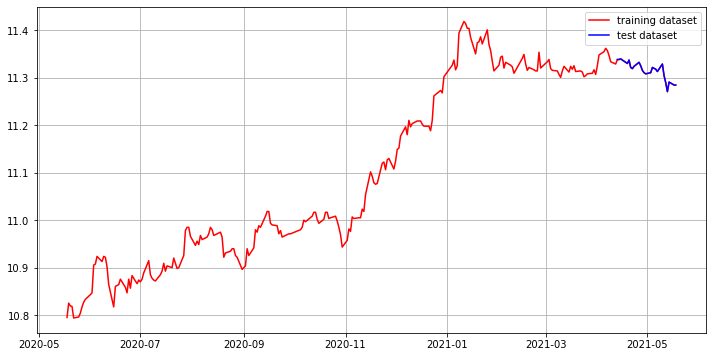

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA 모델

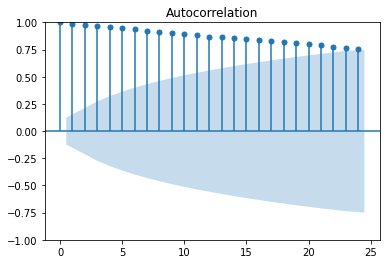

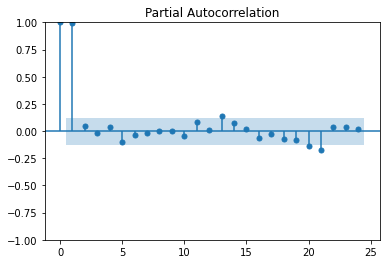

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


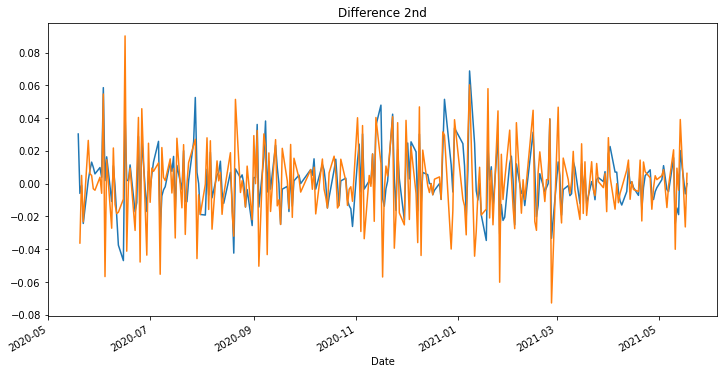

In [15]:
# 1차 차분 구하기
plt.figure(figsize=(12,6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

### 모델 훈련 및 테스트

In [16]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 10 Feb 2022   AIC                          -1156.722
Time:                        06:09:25   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


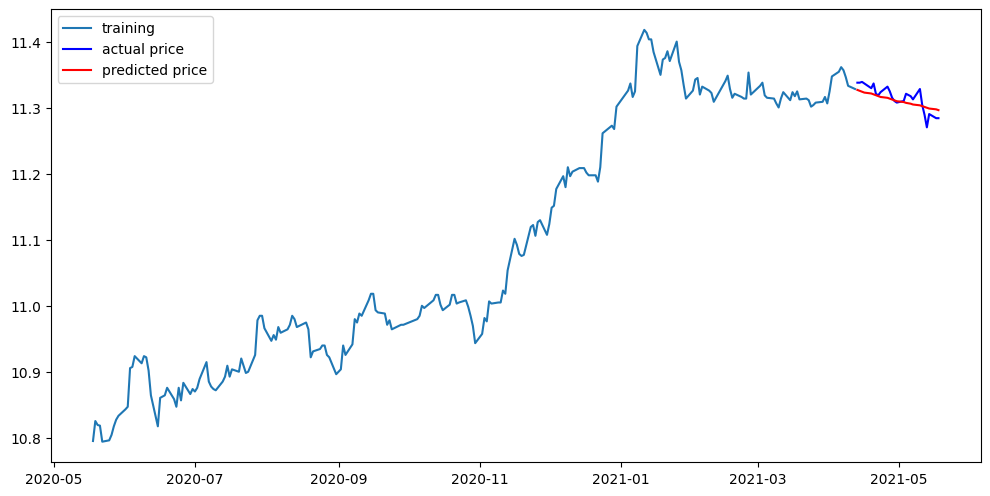

In [17]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측 결과

# plot
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## 셀트리온 주식 예측 

### 데이터 불러오기

In [19]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/068270.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-01-04    340686.28125
2021-01-05    347549.03125
2021-01-06    346568.62500
2021-01-07    350490.18750
2021-01-08    359803.90625
Name: Close, dtype: float64

### 시계열 생성

In [20]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/068270.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-01-04    340686.28125
2021-01-05    347549.03125
2021-01-06    346568.62500
2021-01-07    350490.18750
2021-01-08    359803.90625
Name: Close, dtype: float64

In [21]:
ts.tail()

Date
2021-12-24    197058.828125
2021-12-27    200000.000000
2021-12-28    211764.703125
2021-12-29    201000.000000
2021-12-30    198000.000000
Name: Close, dtype: float64

### 결측치 처리

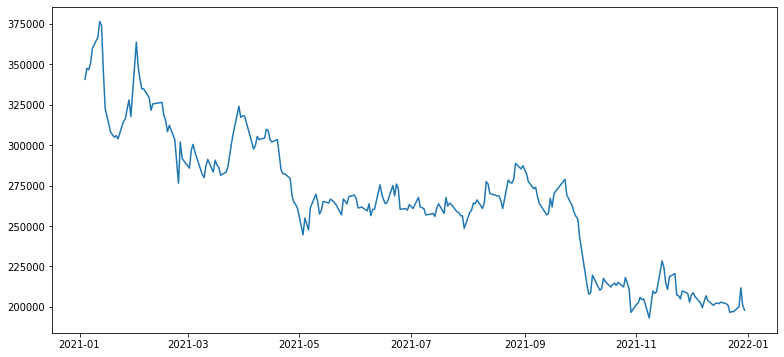

In [22]:
plt.figure(figsize=(13, 6))
plt.plot(ts)

In [23]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 로그 변환

In [24]:
ts_log = np.log(ts)

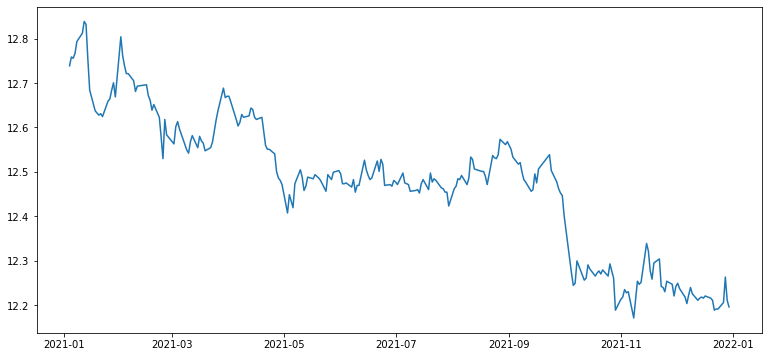

In [25]:
plt.figure(figsize=(13, 6))
plt.plot(ts_log)

### 시계열 안정성 분석

In [26]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [27]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

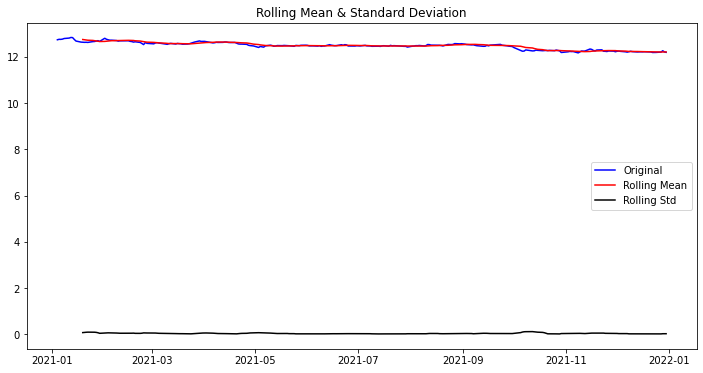

Results of Dickey-Fuller Test:
Test Statistic                  -1.285278
p-value                          0.635880
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


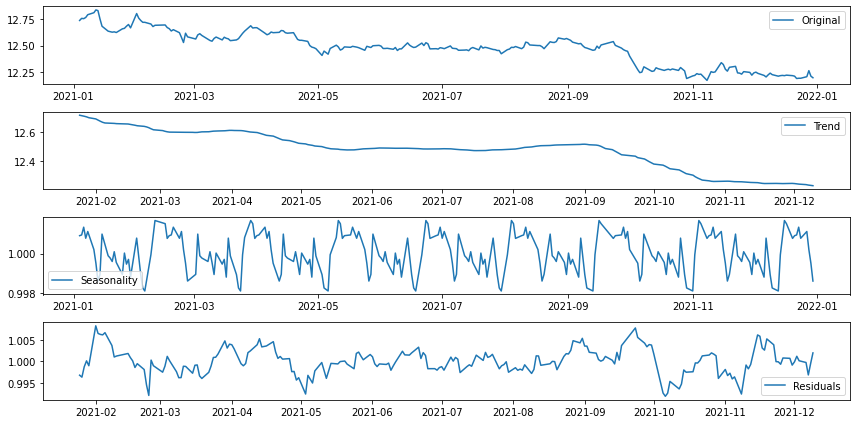

In [28]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.097550e+00
p-value                        1.001584e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


### 데이터셋 생성

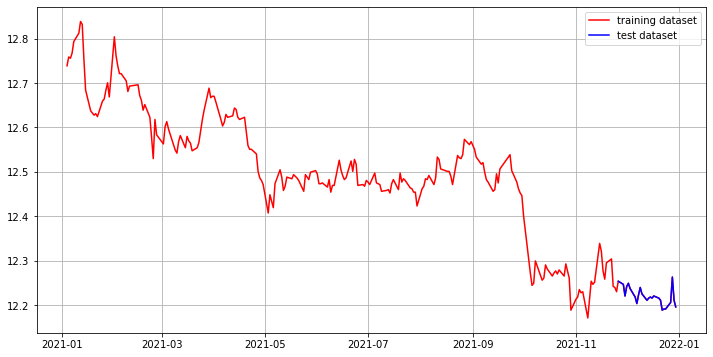

In [30]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA 모델

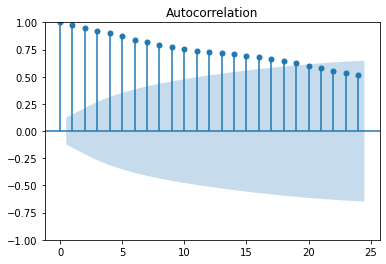

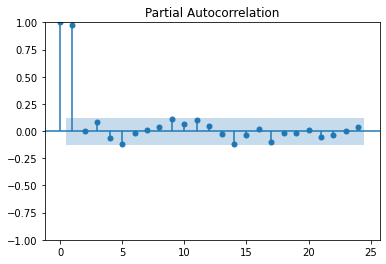

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.206101e+01
p-value                        2.469420e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.206101e+01
p-value                        2.469420e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


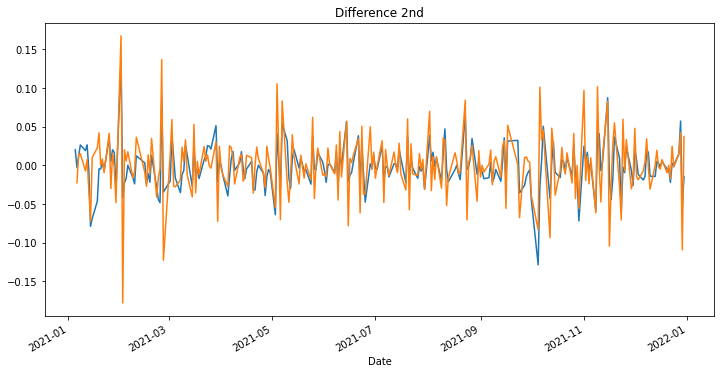

In [32]:
# 1차 차분 구하기
plt.figure(figsize=(12,6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

### 모델 훈련 및 테스트

In [33]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 474.997
Date:                Thu, 10 Feb 2022   AIC                           -939.994
Time:                        06:09:28   BIC                           -922.958
Sample:                             0   HQIC                          -933.116
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4962      0.101    123.298      0.000      12.298      12.695
ar.L1          0.1464      1.998      0.073      0.942      -3.770       4.062
ar.L2          0.8293      1.977      0.420      0.6

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


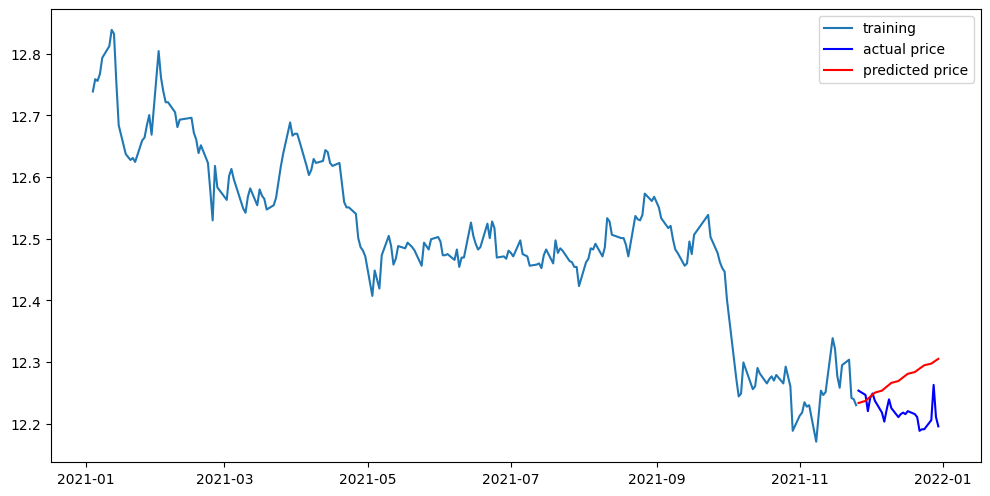

In [34]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  170223875.45603055
MAE:  11104.088944840496
RMSE:  13046.987217592825
MAPE: 5.53%


## 스타벅스 주식 예측

### 데이터 불러오기

In [36]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SBUX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,107.660004,107.750000,102.139999,103.099998,101.423401,8041500
2021-01-05,102.919998,104.260002,102.800003,103.440002,101.757881,5721900
2021-01-06,102.989998,105.209999,102.910004,104.190002,102.495682,5017200
2021-01-07,104.489998,104.639999,102.949997,103.349998,101.669334,5057000
2021-01-08,103.860001,105.760002,103.419998,105.669998,103.951614,5869700


### 시계열 생성

In [37]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SBUX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-01-04    103.099998
2021-01-05    103.440002
2021-01-06    104.190002
2021-01-07    103.349998
2021-01-08    105.669998
Name: Close, dtype: float64

### 결측치 처리

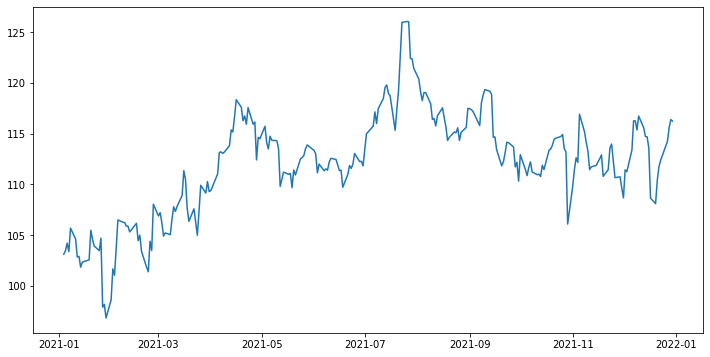

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(ts)

In [39]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 로그 변환

In [40]:
ts_log = np.log(ts)

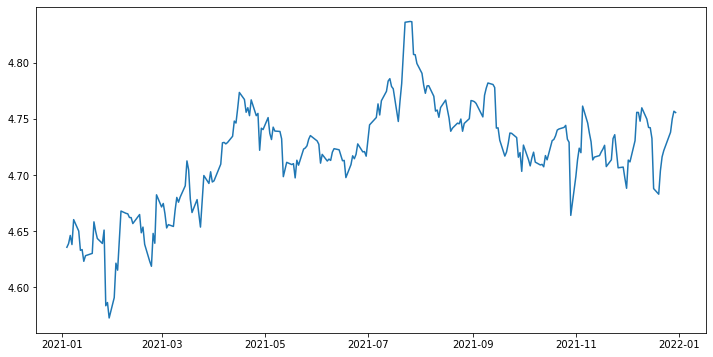

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(ts_log)

### 시계열 안정석 분석

In [42]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [43]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

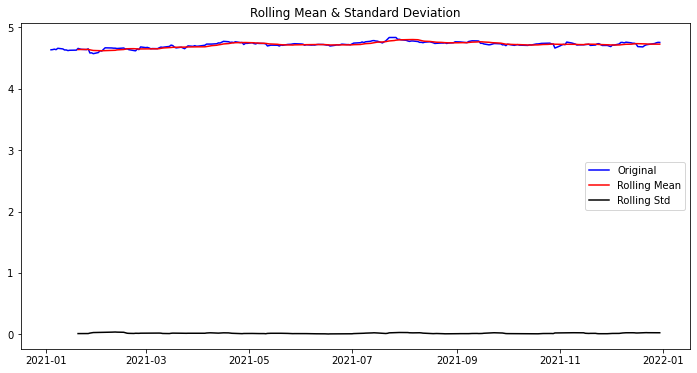

Results of Dickey-Fuller Test:
Test Statistic                  -2.702090
p-value                          0.073677
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


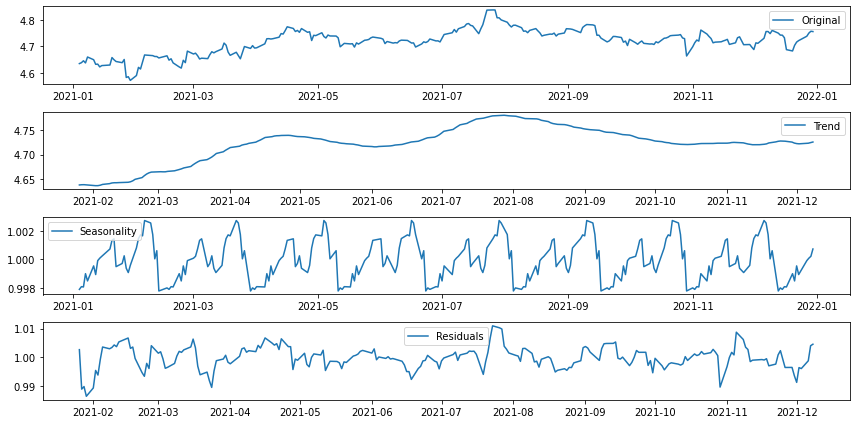

In [44]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.848952e+00
p-value                        1.713842e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


### 데이터셋 생성

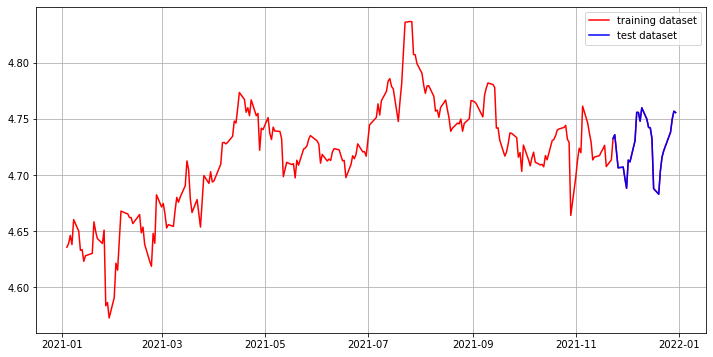

In [46]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA 모델

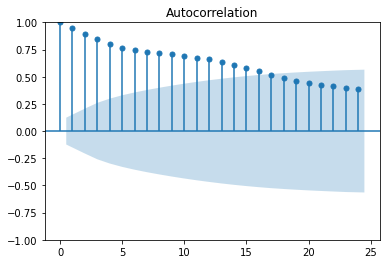

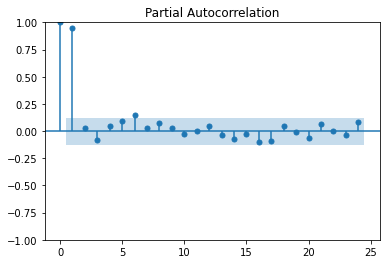

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.184578e+00
p-value                        2.205227e-15
#Lags Used                     4.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.184578e+00
p-value                        2.205227e-15
#Lags Used                     4.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


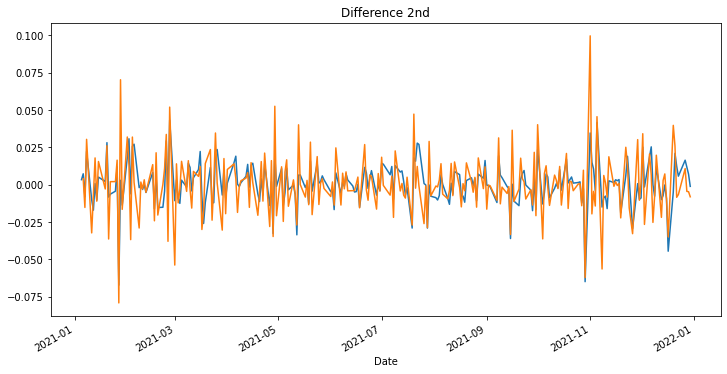

In [48]:
# 1차 차분 구하기
plt.figure(figsize=(12,6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

### 모델 훈련 및 테스트

In [49]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 645.502
Date:                Thu, 10 Feb 2022   AIC                          -1281.003
Time:                        06:09:30   BIC                          -1263.923
Sample:                             0   HQIC                         -1274.110
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7083      0.021    227.153      0.000       4.668       4.749
ar.L1          0.1804      0.221      0.818      0.413      -0.252       0.613
ar.L2          0.7559      0.207      3.654      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


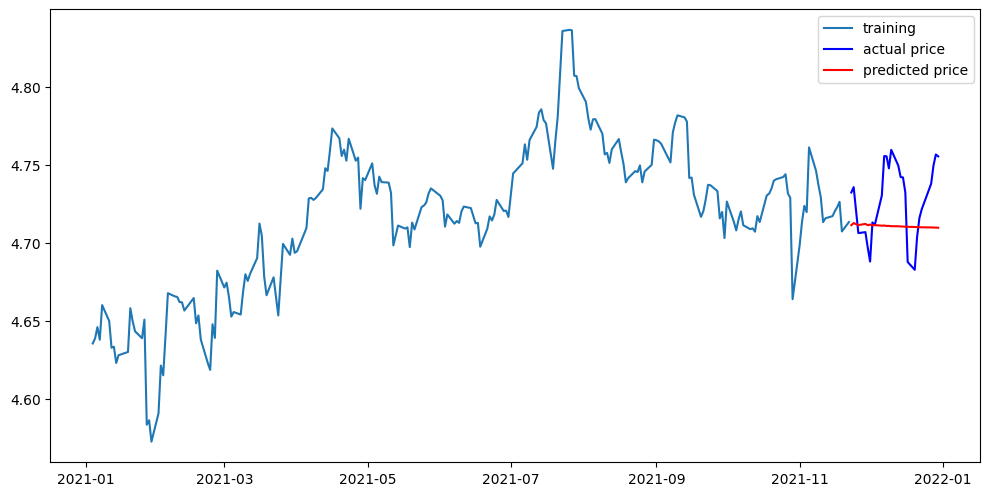

In [50]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10.828759667974342
MAE:  2.8059927534792113
RMSE:  3.2907080800299413
MAPE: 2.46%


## 나이키 주식 예측

### 데이터 불러오기

In [52]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NKE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,142.850006,142.970001,138.320007,140.100006,139.054398,6178500
2021-01-05,138.600006,141.660004,138.600006,141.229996,140.175949,4163100
2021-01-06,141.250000,143.570007,139.529999,142.350006,141.287598,6072900
2021-01-07,143.199997,145.639999,143.000000,144.949997,143.868179,5256900
2021-01-08,145.550003,146.820007,144.899994,146.350006,145.257751,3950500


### 시계열 생성

In [53]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NKE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-01-04    140.100006
2021-01-05    141.229996
2021-01-06    142.350006
2021-01-07    144.949997
2021-01-08    146.350006
Name: Close, dtype: float64

### 결측치 처리

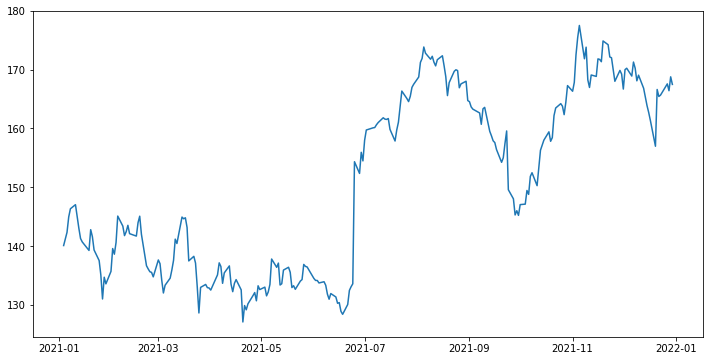

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(ts)

In [55]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 로그 변환

In [56]:
ts_log = np.log(ts)

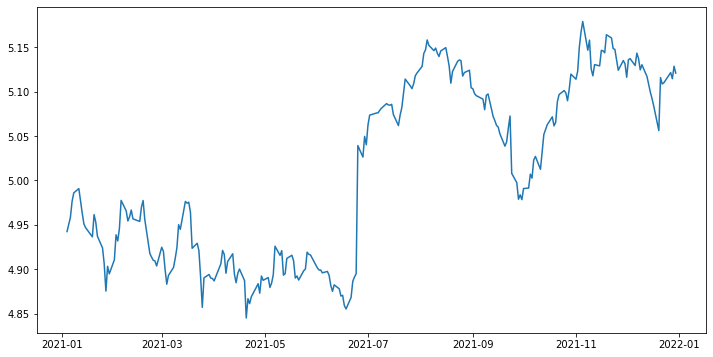

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(ts_log)

### 시계열 안정성 분석

In [58]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [59]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

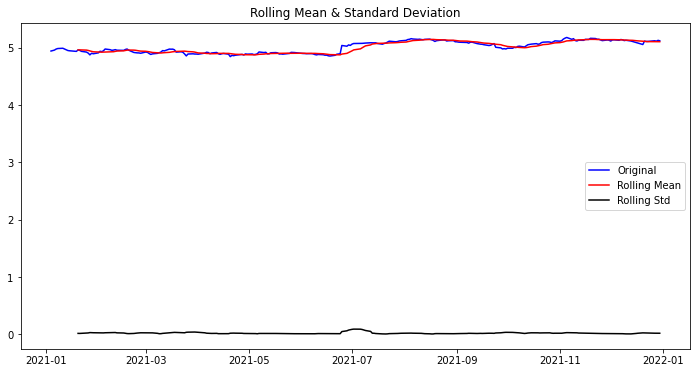

Results of Dickey-Fuller Test:
Test Statistic                  -1.219784
p-value                          0.665028
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


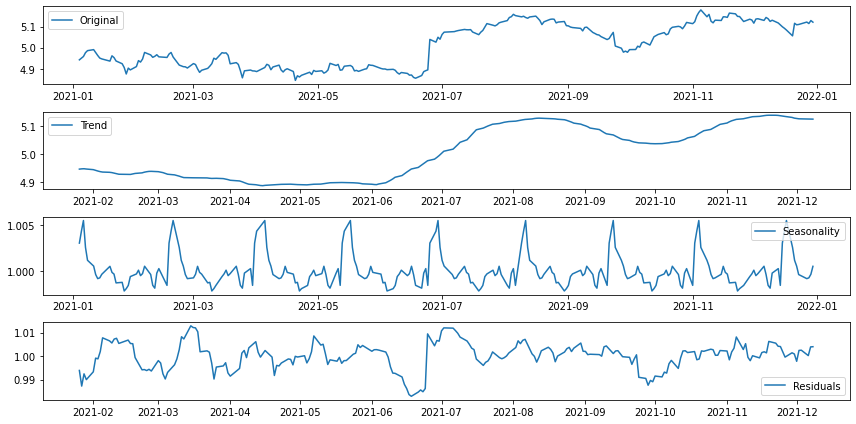

In [60]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [61]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.043047e+00
p-value                        1.331799e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64


### 데이터셋 생성

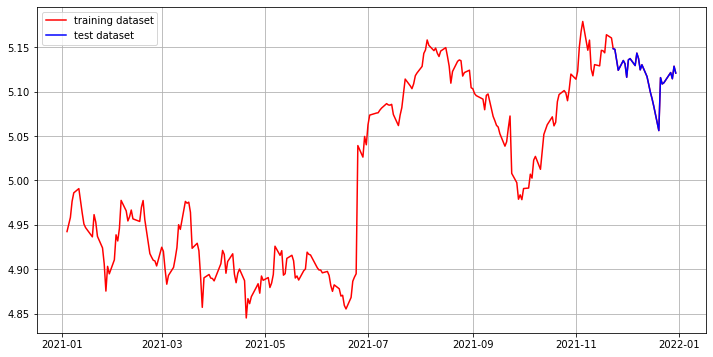

In [62]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA 모델

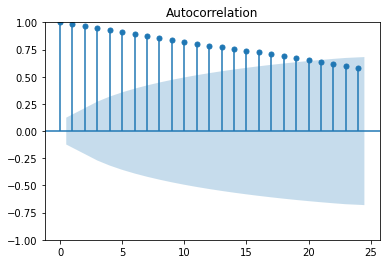

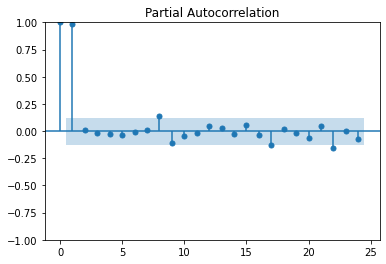

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.609902e+01
p-value                        5.155606e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.609902e+01
p-value                        5.155606e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


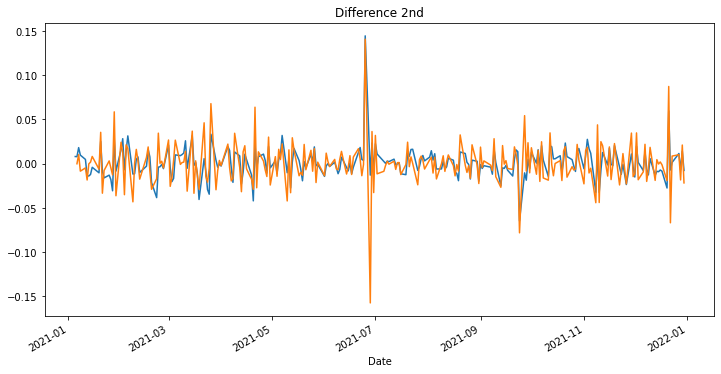

In [64]:
# 1차 차분 구하기
plt.figure(figsize=(12,6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

### 모델 훈련 및 테스트

In [65]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 591.637
Date:                Thu, 10 Feb 2022   AIC                          -1173.273
Time:                        06:09:33   BIC                          -1156.193
Sample:                             0   HQIC                         -1166.379
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0180      0.080     62.669      0.000       4.861       5.175
ar.L1          0.1380      0.662      0.208      0.835      -1.160       1.436
ar.L2          0.8368      0.648      1.291      0.1

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


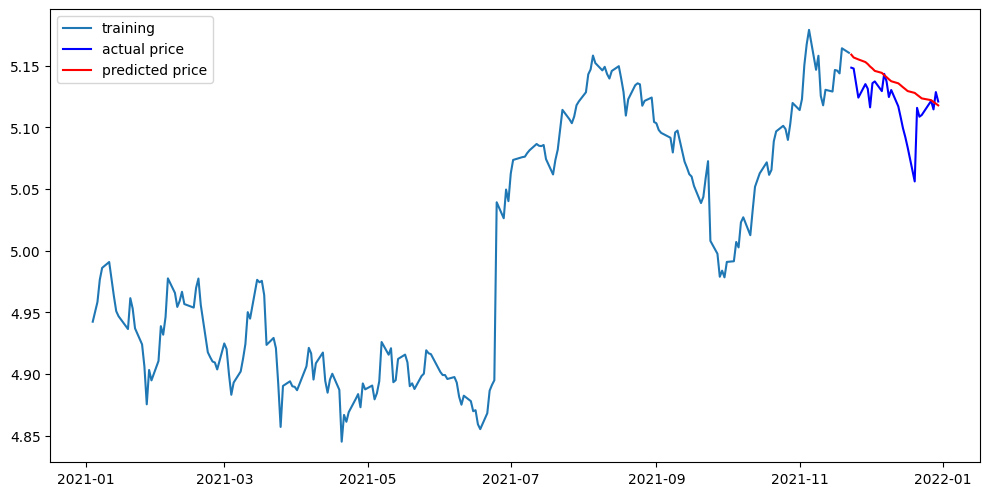

In [66]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  16.17778253149421
MAE:  3.070610565644986
RMSE:  4.022161425340138
MAPE: 1.86%


## 마치며
* 셀트리온
    + MSE:  170223875.45603055
    + MAE:  11104.088944840496
    + RMSE:  13046.987217592825
    + MAPE: 5.53%

* 스타벅스
    + MSE:  10.828759667974342
    + MAE:  2.8059927534792113
    + RMSE:  3.2907080800299413
    + MAPE: 2.46%
    
* 나이키
    + MSE:  16.17778253149421
    + MAE:  3.070610565644986
    + RMSE:  4.022161425340138
    + MAPE: 1.86%
    
* 나이키의 MAPE 값이 가장 적음.
    + 셀트리온 > 스타벅스 > 나이키
* 이전 데이터를 바탕으로 모델을 학습시켰을 때, 약간 엉뚱한 방향으로 예측하고 있음.
    + 굴곡이 있어야 하나 거의 직선으로 예측.
* 이 모델로 주식을 예측하기엔 물가 변동과 우연성, 개연성 등을 모두 고려할 수 없음으로 실제로 사용하기엔 현실적으로 어려움.